In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
import numpy as np

In [32]:
import re

In [33]:
sentences = """The forest is home to thousands of plants and animals.
Rivers flow through the valleys providing water to the land.
Birds migrate across continents in search of food and better climate.
Mountains stand tall and protect the region from strong winds.
Nature balances life and every creature has an important role to play."""

In [34]:
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()
sentences = sentences.lower()

In [35]:
words = sentences.split()
vocab = set(words)

In [36]:
vocab_len = len(vocab)
embed_dim = 10
context_size = 2

In [37]:
word_to_ix = {}
ix_to_word = {}

i = 0
for word in vocab:
    word_to_ix[word] = i
    ix_to_word[i] = word
    i += 1

In [38]:
data = []
for i in range(2, len(words) - 2):
    context = [words[i-2], words[i-1], words[i+1], words[i+2]]
    target = words[i]
    data.append((context, target))
print(data)

[(['the', 'forest', 'home', 'to'], 'is'), (['forest', 'is', 'to', 'thousands'], 'home'), (['is', 'home', 'thousands', 'of'], 'to'), (['home', 'to', 'of', 'plants'], 'thousands'), (['to', 'thousands', 'plants', 'and'], 'of'), (['thousands', 'of', 'and', 'animals'], 'plants'), (['of', 'plants', 'animals', 'rivers'], 'and'), (['plants', 'and', 'rivers', 'flow'], 'animals'), (['and', 'animals', 'flow', 'through'], 'rivers'), (['animals', 'rivers', 'through', 'the'], 'flow'), (['rivers', 'flow', 'the', 'valleys'], 'through'), (['flow', 'through', 'valleys', 'providing'], 'the'), (['through', 'the', 'providing', 'water'], 'valleys'), (['the', 'valleys', 'water', 'to'], 'providing'), (['valleys', 'providing', 'to', 'the'], 'water'), (['providing', 'water', 'the', 'land'], 'to'), (['water', 'to', 'land', 'birds'], 'the'), (['to', 'the', 'birds', 'migrate'], 'land'), (['the', 'land', 'migrate', 'across'], 'birds'), (['land', 'birds', 'across', 'continents'], 'migrate'), (['birds', 'migrate', 'c

In [39]:
embeddings = np.random.random_sample((vocab_len, embed_dim))

In [40]:
#hidden → output layer
def linear(m, theta):
    w = theta
    return m.dot(w)

In [41]:
def log_softmax(x):
    e_x = np.exp(x - np.max(x)) # softmax to prevent overflow
    return np.log(e_x / e_x.sum()) # 

In [42]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [43]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- out + softmax) / logits.shape[0]

In [44]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    
    return m, n, o

In [45]:
def backward(preds, theta, target_idxs):
    m, n, o = preds
    
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    
    return dw

In [46]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

In [47]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_len))

In [48]:
epoch_losses = {}

for epoch in range(150):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
        
     
    epoch_losses[epoch] = losses

Text(0, 0.5, 'Losses')

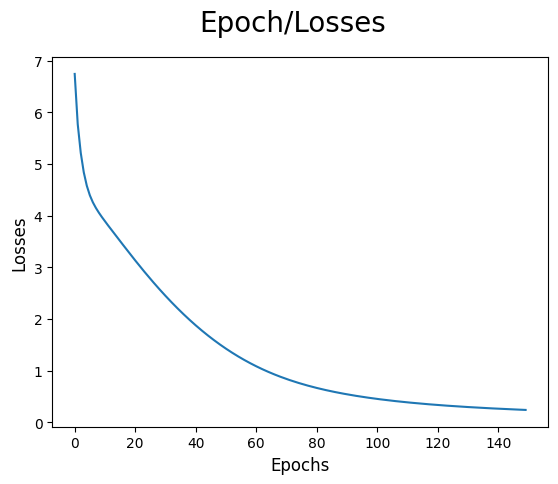

In [57]:
ix = np.arange(0,150)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

Predict Function

In [50]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    
    return word

In [51]:
predict(['forest', 'is', 'to', 'thousands'])

'home'

In [52]:
predict(['nature', 'balances', 'and', 'every'])

'life'

In [53]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1
            
    return (1 - (wrong / len(data)))

In [54]:
accuracy()

1.0

In [55]:
# Simple user input for prediction
print("Word Prediction using CBOW Model")
print("Enter 4 context words (space separated):")

user_input = input("Context words: ").strip().lower()
context_words = user_input.split()

if len(context_words) == 4:
    # Check if all words are in vocabulary
    valid_words = all(word in vocab for word in context_words)
    
    if valid_words:
        predicted_word = predict(context_words)
        print(f"\nContext: {context_words}")
        print(f"Predicted target word: '{predicted_word}'")
    else:
        print(f"\nError: One or more words not in vocabulary.")
        print(f"Available vocabulary: {list(vocab)}")
else:
    print("Please enter exactly 4 words.")

Word Prediction using CBOW Model
Enter 4 context words (space separated):
Please enter exactly 4 words.


In [56]:
#  Testcases 
# 'rivers', 'flow', 'the', 'valleys - through
# 'forest', 'is', 'to', 'thousands']) - home 
# 'nature', 'balances', 'and', 'every' - life